# Drought Center of Mass

a. stein 7.7.2022

Perhaps a way to evaluate spatial changes is ot calculate a center of mass weighted by higher drought categories having a bigger drag on the center.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


Load in the paired data, cause why not

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [3]:
test_img = paired_ds['USDM'].isel(index=500)

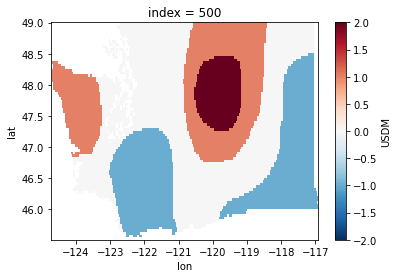

In [4]:
test_img.plot()

In [5]:
from scipy import ndimage

In [6]:
ndimage.measurements.center_of_mass(test_img.values)

(nan, nan)

In [7]:
test_vals = test_img.values
test_vals.shape

(84, 188)

In [8]:
lats = test_img.lat.values
lons = test_img.lon.values

In [9]:
test_vals = test_img.values

In [10]:
test_vals += 2

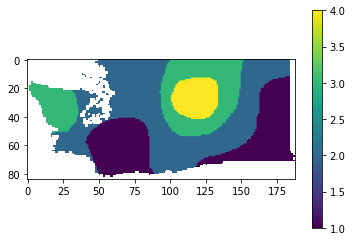

In [11]:
fig, ax = plt.subplots()

plotted = ax.imshow(test_vals)
fig.colorbar(plotted)

In [12]:
test_vals[np.isnan(test_vals)] = 0

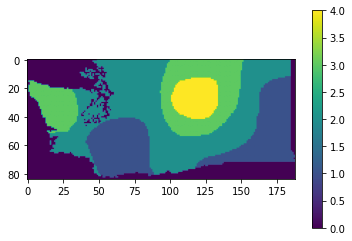

In [13]:
fig, ax = plt.subplots()

plotted = ax.imshow(test_vals)
fig.colorbar(plotted)

In [14]:
com_y, com_x = ndimage.measurements.center_of_mass(test_vals)
(com_x, com_y)

(100.41550418493424, 34.31060183339976)

In [15]:
test_vals[test_vals == 0] = np.nan

In [16]:
test_vals -= 2

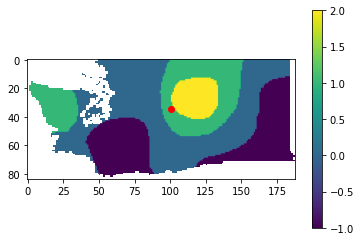

In [17]:
fig, ax = plt.subplots()

plotted = ax.imshow(test_vals)
fig.colorbar(plotted)

ax.scatter(com_x, com_y, color='r')

Cool, that works and makes sense, let's wrap it up into a function

In [18]:
def get_usdmcat_com(data:np.ndarray):
    """Compute center of mass for USDM category data.

    Parameters
    ----------
    data: np.ndarray
        Contains values ranging from -1 to 4 according
        to USDM category gridding, with empty cells
        being set to np.nan
    
    Returns
    -------
    x, y : float
        Center of mass coordinates in x and y computed
        by ndimage.measurements.center_of_mass
    
    """
    
    # shift everything to positive nonzero
    data += 2
    # replace nans with zero mass
    data[np.isnan(data)] = 0

    # compute center of mass
    com_y, com_x = ndimage.measurements.center_of_mass(data)

    return com_x, com_y

Now I want to get it for all of USDM

In [19]:
usdm_com_x = []
usdm_com_y = []

for idx in paired_ds.index:
    com_x, com_y = get_usdmcat_com(paired_ds['USDM'].sel(index=idx).values)
    usdm_com_x.append(com_x)
    usdm_com_y.append(com_y)

Let's convert into coordinates

In [20]:
usdm_com_x_coords = ((lons[-1]- lons[0])*(np.array(usdm_com_x)/(len(lons))))+lons[0]
usdm_com_x_coords

array([-120.46209873, -120.46209873, -120.46209873, ..., -119.58175523,
       -119.6072639 , -119.63328661])

In [21]:
usdm_com_y_coords = ((lats[-1] - lats[0])*(np.array(usdm_com_y)/len(lats)))+lats[0]
usdm_com_y_coords

array([47.39775673, 47.39775673, 47.39775673, ..., 47.22803329,
       47.23620937, 47.23722538])

Going to double check that I didn't mess up the transform

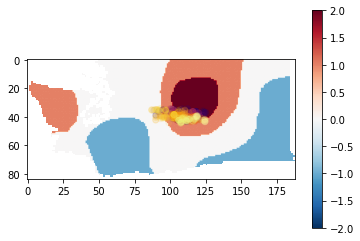

In [22]:
# in index form

fig, ax = plt.subplots()

ax.scatter(usdm_com_x, usdm_com_y, c=np.arange(len(usdm_com_x)), cmap='inferno', alpha=0.1)
plotted = ax.imshow(test_vals, cmap='RdBu_r', vmin=-2, vmax=2)
fig.colorbar(plotted)

ax.set_aspect('equal')

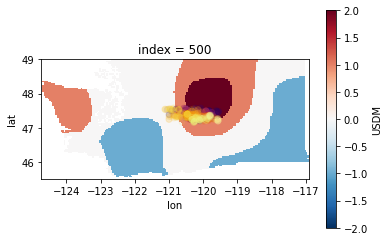

In [23]:
# now transformed to coordinate form

fig, ax = plt.subplots()

test_img.plot(ax=ax)
ax.scatter(usdm_com_x_coords, usdm_com_y_coords, c=np.arange(len(usdm_com_x)), cmap='inferno', alpha=0.1)

ax.set_aspect('equal')

that looks good, can I do it with just the outline now?

In [24]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)
wa_gdf = states_gdf[(states_gdf.NAME=='Washington')]

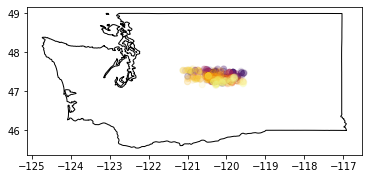

In [25]:
fig, ax = plt.subplots()

wa_gdf.plot(color='none', edgecolor='k', ax=ax)
ax.scatter(usdm_com_x_coords, usdm_com_y_coords, c=np.arange(len(usdm_com_x)), cmap='inferno', alpha=0.1)
ax.set_aspect('equal')

Fab. Let's now compare to SPI and such

But first let's wrap that transform into a function

In [26]:
def transform_index_to_coords(idx_data:np.ndarray, coord_ref:np.ndarray):
    return ((coord_ref[-1] - coord_ref[0])*idx_data/len(coord_ref))+coord_ref[0]

Double check didn't mess up

In [27]:
np.where(usdm_com_x_coords != transform_index_to_coords(np.array(usdm_com_x), lons))

(array([ 108,  263,  918,  919,  954,  955,  956,  977,  979,  980,  981,
        1114]),)

Gdi. What's up

(array([   9.,    0.,    0.,    0.,    0., 1136.,    0.,    0.,    0.,
           3.]),
 array([-1.42108547e-14, -1.13686838e-14, -8.52651283e-15, -5.68434189e-15,
        -2.84217094e-15,  0.00000000e+00,  2.84217094e-15,  5.68434189e-15,
         8.52651283e-15,  1.13686838e-14,  1.42108547e-14]),
 <BarContainer object of 10 artists>)

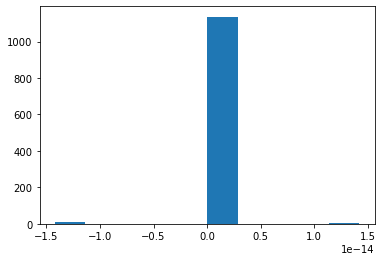

In [28]:
fig, ax = plt.subplots()
ax.hist(usdm_com_x_coords - transform_index_to_coords(np.array(usdm_com_x), lons))

Cool, that's rounding error, we move on.

Let's toss this all into 1 function so I don't have to remember the steps

In [29]:
def compute_usdmcat_com_coords(da:xr.DataArray):

    com_x_list = []
    com_y_list = []

    for idx in da.index:
        com_x, com_y = get_usdmcat_com(da.sel(index=idx).values)
        com_x_list.append(com_x) 
        com_y_list.append(com_y)


    com_x_coords = transform_index_to_coords(np.array(com_x_list), da.lon.values)
    com_y_coords = transform_index_to_coords(np.array(com_y_list), da.lat.values)

    return com_x_coords, com_y_coords

In [30]:
func_test_x, func_test_y = compute_usdmcat_com_coords(paired_ds['USDM'])

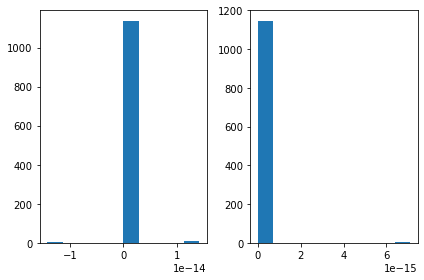

In [31]:
fig, ax = plt.subplots(1,2)

ax[0].hist(func_test_x - usdm_com_x_coords)
ax[1].hist(func_test_y - usdm_com_y_coords)

plt.tight_layout()

Woot. Now I can move on to tossing SPI in the mix.

### Make some plots, see if useful

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


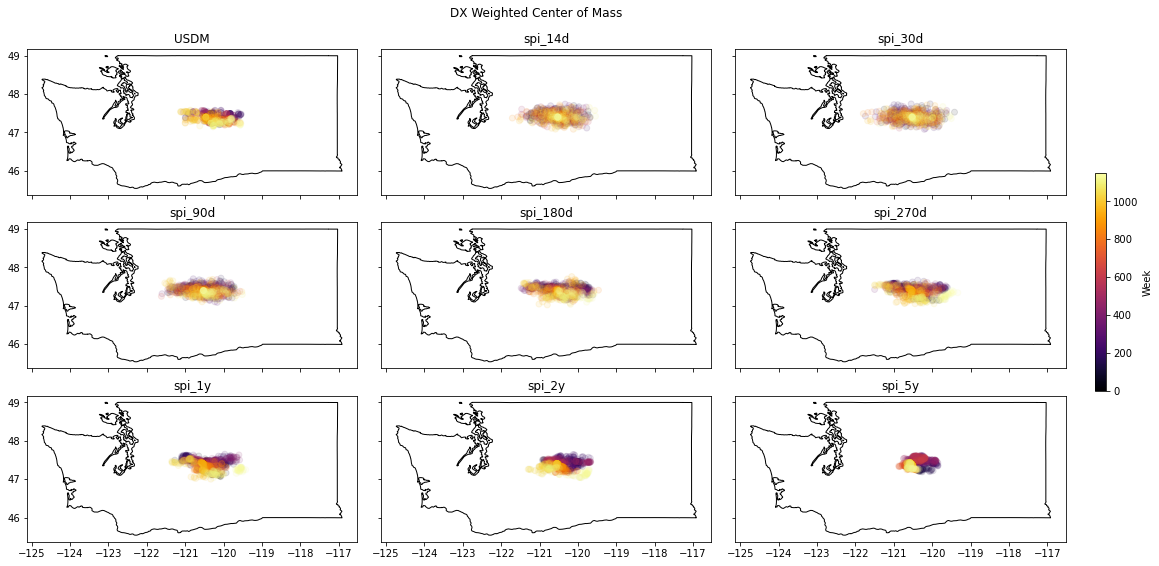

In [32]:
fig, axs = plt.subplots(3,3, figsize=(15,8), sharex=True, sharey=True)

for dm_var, ax in zip(dm_vars, axs.ravel()):

    wa_gdf.plot(ax=ax, color='none', edgecolor='k')
    
    com_x_coords, com_y_coords = compute_usdmcat_com_coords(paired_ds[dm_var])
    ax.scatter(com_x_coords, com_y_coords, c=np.arange(len(paired_ds.index)), cmap='inferno', alpha=0.1)

    ax.set_title(dm_var)
    ax.set_aspect('equal')

fig.colorbar(plt.cm.ScalarMappable(cmap='inferno', norm=mpl.colors.Normalize(vmin=0, vmax=len(paired_ds.index))), ax=axs, shrink=0.5, anchor=(2.2, 0.5), label='Week')

fig.suptitle('DX Weighted Center of Mass')

plt.tight_layout()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


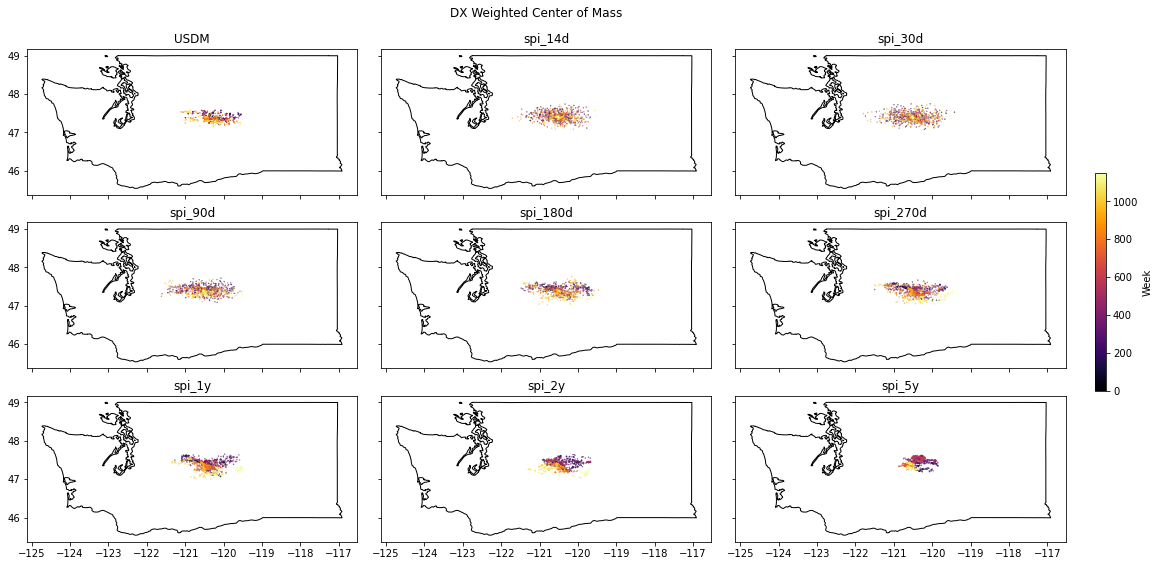

In [33]:
fig, axs = plt.subplots(3,3, figsize=(15,8), sharex=True, sharey=True)

for dm_var, ax in zip(dm_vars, axs.ravel()):

    wa_gdf.plot(ax=ax, color='none', edgecolor='k')
    
    com_x_coords, com_y_coords = compute_usdmcat_com_coords(paired_ds[dm_var])
    ax.scatter(com_x_coords, com_y_coords, c=np.arange(len(paired_ds.index)), cmap='inferno', alpha=1, s=0.1)

    ax.set_title(dm_var)
    ax.set_aspect('equal')

fig.colorbar(plt.cm.ScalarMappable(cmap='inferno', norm=mpl.colors.Normalize(vmin=0, vmax=len(paired_ds.index))), ax=axs, shrink=0.5, anchor=(2.2, 0.5), label='Week')

fig.suptitle('DX Weighted Center of Mass')

plt.tight_layout()

The biggest thing I'm noticing is changes in East/West spread much more than changes in North/West spread depending on the measure ... but some do appear to have a Southern drift as time goes on. Would need to do more thinking about what these might mean

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


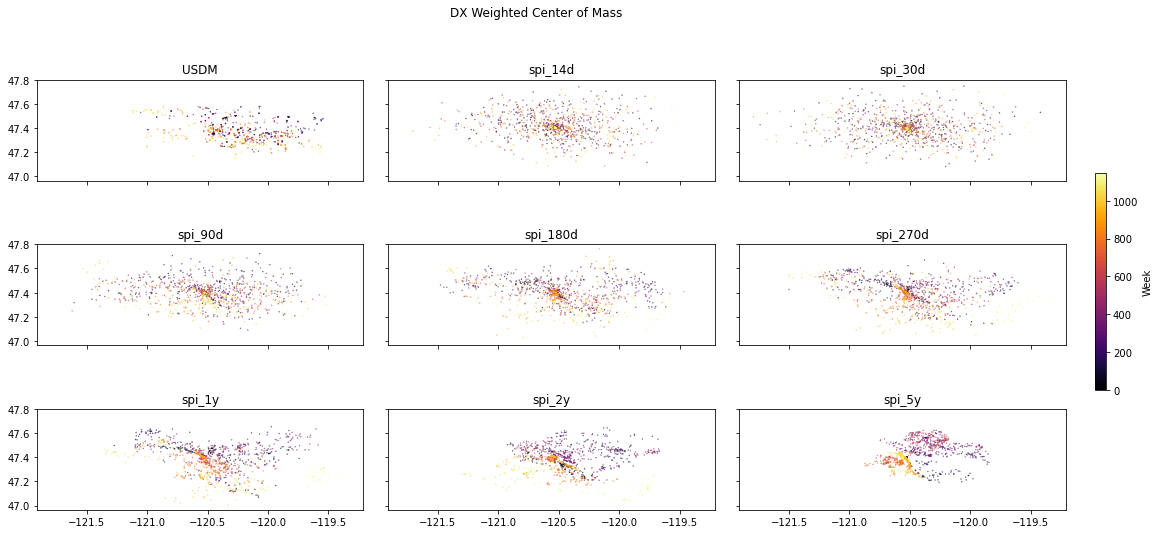

In [34]:
fig, axs = plt.subplots(3,3, figsize=(15,8), sharex=True, sharey=True)

for dm_var, ax in zip(dm_vars, axs.ravel()):

    
    com_x_coords, com_y_coords = compute_usdmcat_com_coords(paired_ds[dm_var])
    ax.scatter(com_x_coords, com_y_coords, c=np.arange(len(paired_ds.index)), cmap='inferno', alpha=1, s=0.1)

    ax.set_title(dm_var)
    ax.set_aspect('equal')

fig.colorbar(plt.cm.ScalarMappable(cmap='inferno', norm=mpl.colors.Normalize(vmin=0, vmax=len(paired_ds.index))), ax=axs, shrink=0.5, anchor=(2.2, 0.5), label='Week')

fig.suptitle('DX Weighted Center of Mass')

plt.tight_layout()

In [35]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


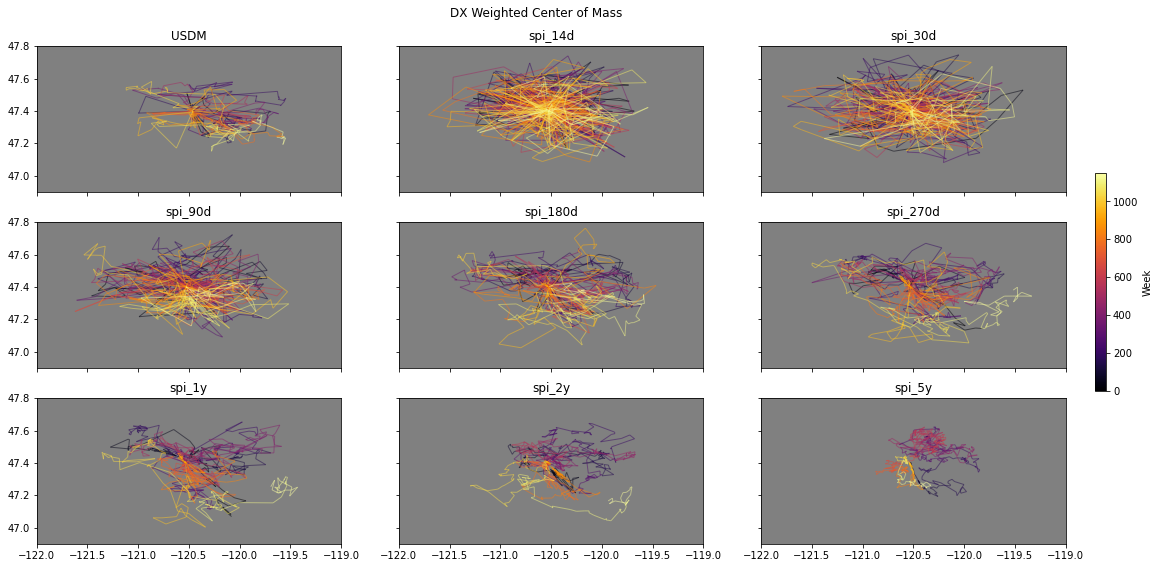

In [36]:
fig, axs = plt.subplots(3,3, figsize=(15,8), sharex=True, sharey=True)

color_vals = np.arange(len(paired_ds.index))
norm = plt.Normalize(color_vals.min(), color_vals.max())

for dm_var, ax in zip(dm_vars, axs.ravel()):

    com_x_coords, com_y_coords = compute_usdmcat_com_coords(paired_ds[dm_var])
    points = np.array([com_x_coords, com_y_coords]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)    

    lc = LineCollection(segments, cmap='inferno', norm=norm)
    lc.set_array(color_vals)
    lc.set_linewidth(1)
    lc.set_alpha(0.5)
    line = ax.add_collection(lc)

    ax.set_xlim(-122, -119)
    ax.set_ylim(46.9, 47.8)

    ax.set_title(dm_var)
    ax.set_facecolor('gray')

fig.colorbar(plt.cm.ScalarMappable(cmap='inferno', norm=mpl.colors.Normalize(vmin=0, vmax=len(paired_ds.index))), ax=axs, shrink=0.5, anchor=(2.2, 0.5), label='Week')

fig.suptitle('DX Weighted Center of Mass')

plt.tight_layout()
plt.show()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


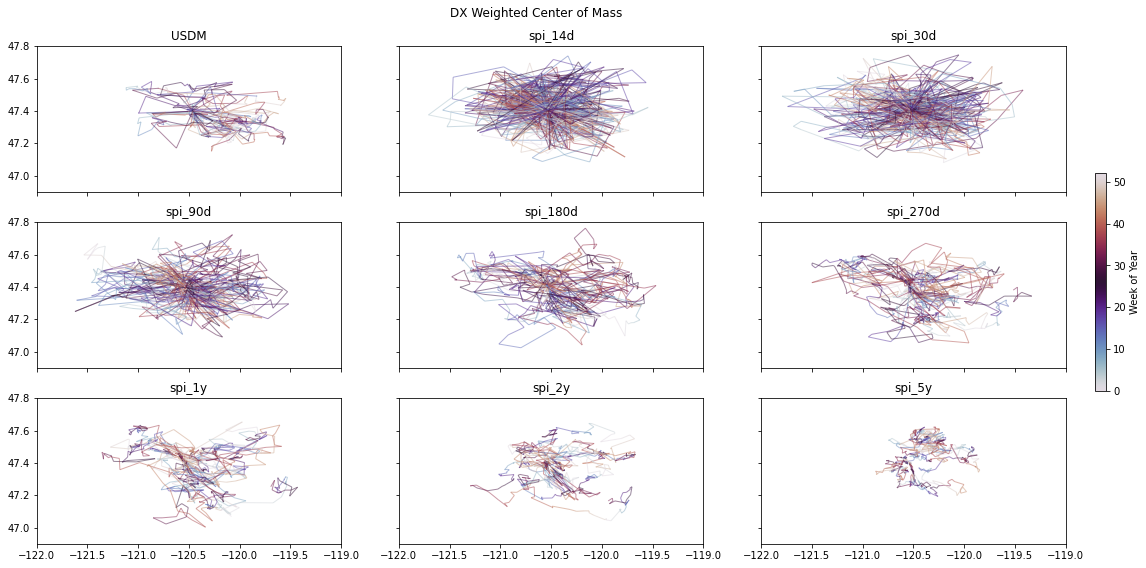

In [48]:
fig, axs = plt.subplots(3,3, figsize=(15,8), sharex=True, sharey=True)

color_vals = (np.arange(len(paired_ds.index))%53)/52
norm = plt.Normalize(color_vals.min(), color_vals.max())
cmap = 'twilight'

for dm_var, ax in zip(dm_vars, axs.ravel()):

    com_x_coords, com_y_coords = compute_usdmcat_com_coords(paired_ds[dm_var])
    points = np.array([com_x_coords, com_y_coords]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)    

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(color_vals)
    lc.set_linewidth(1)
    lc.set_alpha(0.5)
    line = ax.add_collection(lc)

    ax.set_xlim(-122, -119)
    ax.set_ylim(46.9, 47.8)

    ax.set_title(dm_var)
    #ax.set_facecolor('gray')

fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=52)), ax=axs, shrink=0.5, anchor=(2.2, 0.5), label='Week of Year')

fig.suptitle('DX Weighted Center of Mass')

plt.tight_layout()
plt.show()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


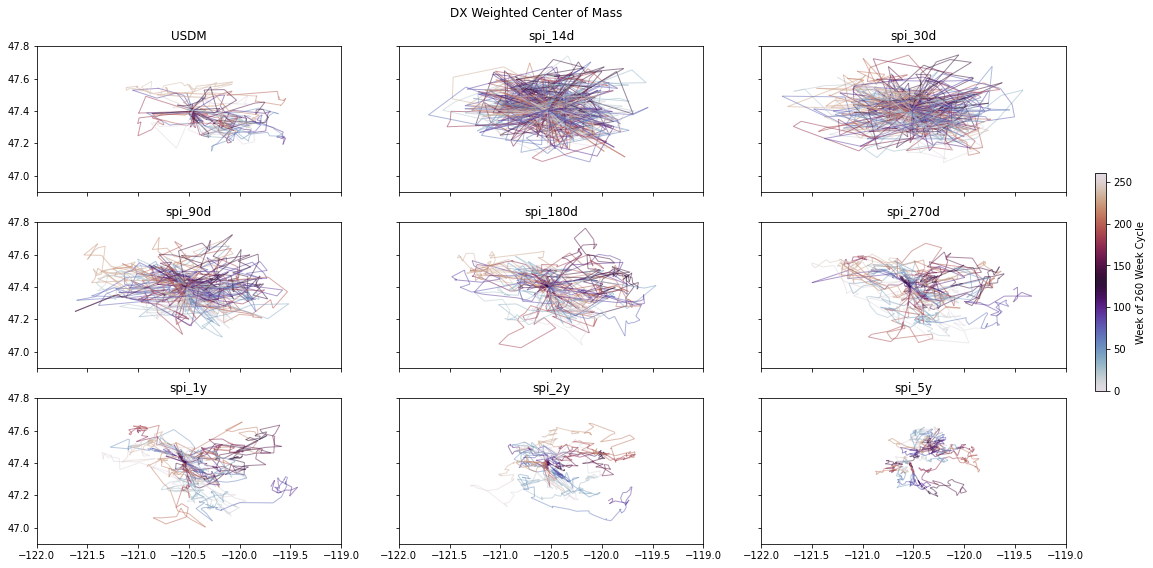

In [56]:
fig, axs = plt.subplots(3,3, figsize=(15,8), sharex=True, sharey=True)

time_window = 52*5
color_vals = (np.arange(len(paired_ds.index))%(time_window+1))/(time_window)
norm = plt.Normalize(color_vals.min(), color_vals.max())
cmap = 'twilight'

for dm_var, ax in zip(dm_vars, axs.ravel()):

    com_x_coords, com_y_coords = compute_usdmcat_com_coords(paired_ds[dm_var])
    points = np.array([com_x_coords, com_y_coords]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)    

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(color_vals)
    lc.set_linewidth(1)
    lc.set_alpha(0.5)
    line = ax.add_collection(lc)

    ax.set_xlim(-122, -119)
    ax.set_ylim(46.9, 47.8)

    ax.set_title(dm_var)
    #ax.set_facecolor('gray')

fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=time_window)), ax=axs, shrink=0.5, anchor=(2.2, 0.5), label=f'Week of {time_window} Week Cycle')

fig.suptitle('DX Weighted Center of Mass')

plt.tight_layout()
plt.show()